## Choix d'un horizon de 5 ans

- Période de référence: 2017-2020
- Choix du portefeuille optimal au sens de Markowitz
- Evolution de la valeur du portefeuille depuis 2017

In [1]:
## TELECHARGEMENT DES DONNEES AVEC YFINANCE

import pandas as pd
import yfinance as yf
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from PEA_allocation import *

start, end = ['2017-01-01', '2020-01-01']

etf_info = pd.read_excel('data/ETF_Boursorama_top150_clean.xlsx')
etf_info.set_index('Symbol', inplace = True)

s, tickers = [], etf_info.index
for ticker in tickers:
    tick_hist = yf.Ticker(ticker).history(start = start, end = end)
    s.append(tick_hist['Open'])

- PMEU.PA: Data doesn't exist for startDate = 1483225200, endDate = 1577833200
- CSX5.PA: No data found for this date range, symbol may be delisted
- CEMU.PA: No data found for this date range, symbol may be delisted
- VEUR.PA: No data found for this date range, symbol may be delisted
- TELE.PA: No data found for this date range, symbol may be delisted


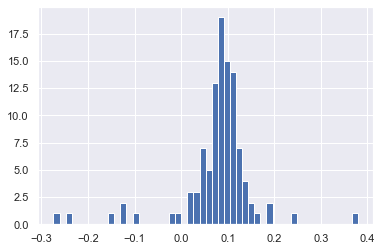

In [2]:
# Drop and fill missing values
df_open = pd.concat(s, axis = 1)
df_open.columns = tickers

df_open.drop(df_open.columns[df_open.isna().all()], axis = 1, inplace = True)
df_open.drop(df_open.columns[df_open.apply(lambda x: sum(x.isna())) > 0.1 * df_open.shape[0]], 
             inplace = True, axis = 1)
df_open.fillna(method = 'backfill', axis = 0, inplace = True)
df_open.drop(['CAPE.PA', 'EEMU.PA'], axis = 1, inplace = True) # Outlier values

df_historical_return = (df_open.diff(1) / df_open.shift(1)) * 252
historical_returns_mean = df_historical_return.mean()
historical_returns_mean.hist(bins = 50)

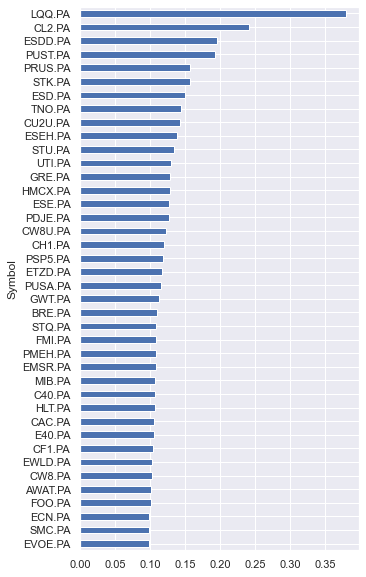

In [3]:
historical_returns_mean.sort_values(ascending = True).tail(40).plot.barh(figsize=(5,10))

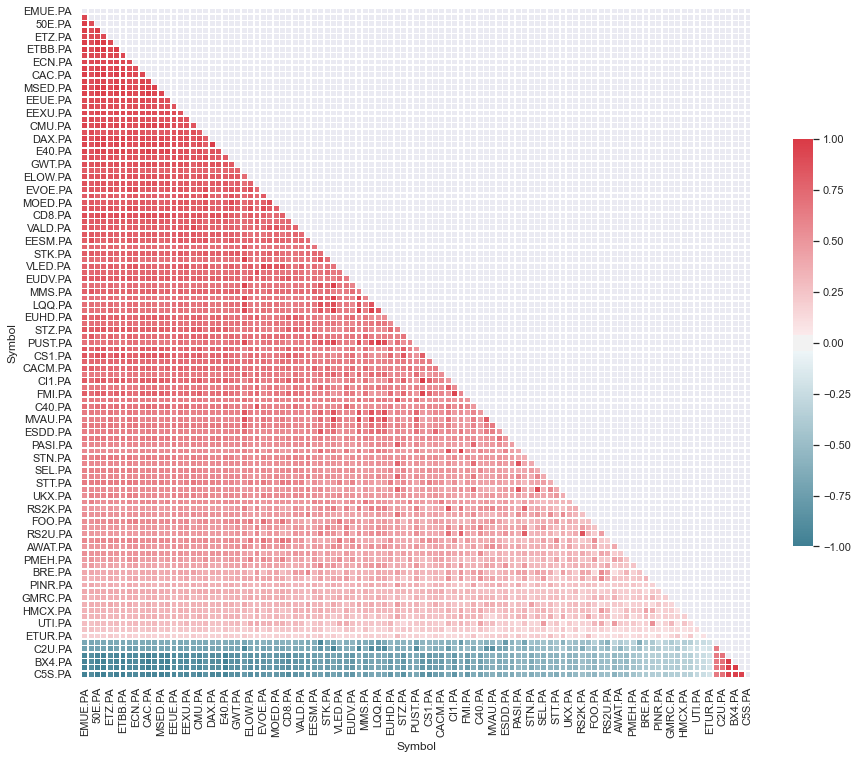

In [13]:
# Estimation de la matrice de covariance des returns
# For analysis, plot correlation matrix rather than covariance

historical_returns_cov = df_historical_return.cov() * 1/252
corr = df_historical_return.corr()
plot_correlation_matrix(corr)

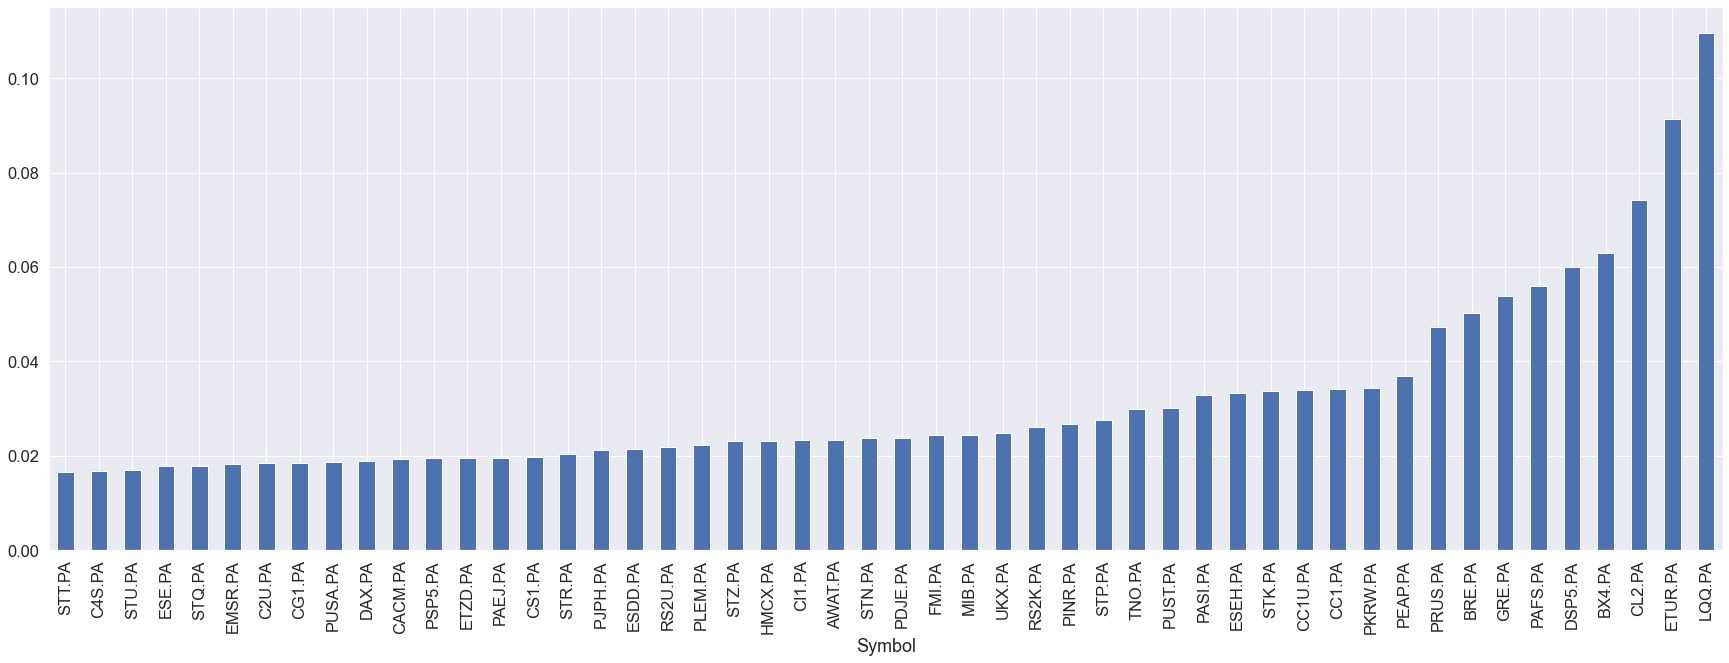

In [7]:
# Top-10 daily volatility

sns.set(font_scale=1.5, rc={'figure.figsize':(30, 10)})

historical_returns_cov_diag = pd.Series(np.diag(historical_returns_cov), index=historical_returns_cov.columns)
historical_returns_cov_diag.sort_values().tail(50).plot.bar()

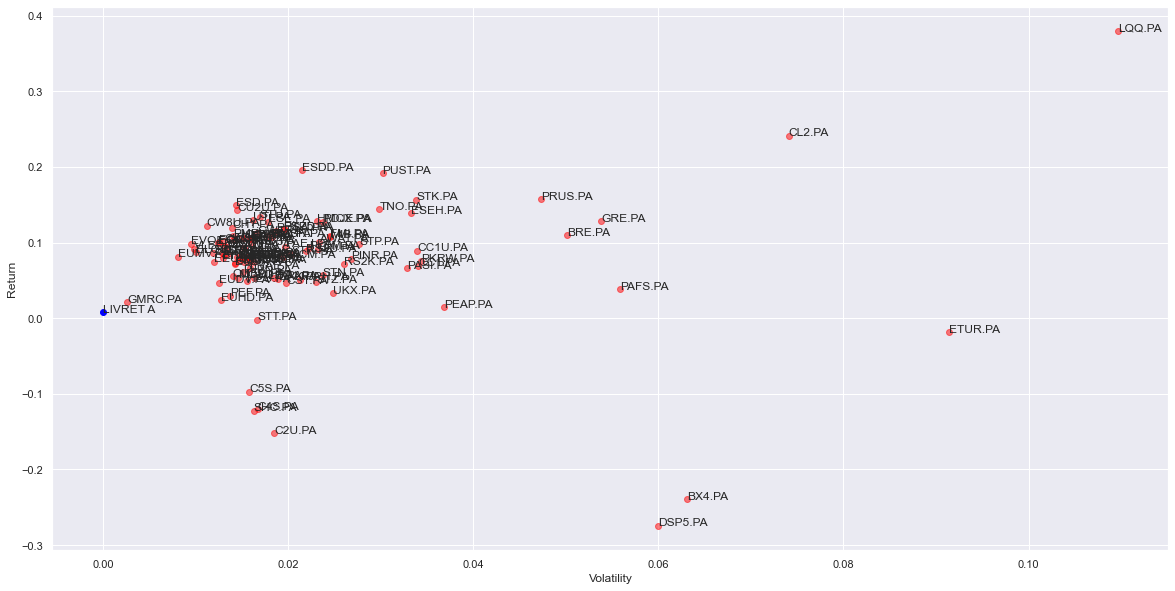

In [8]:
sns.set(font_scale=1, rc={'figure.figsize':(20, 10)})

for i in historical_returns_mean.index:
    plt.annotate(i, (historical_returns_cov_diag[i], historical_returns_mean[i]))
    plt.scatter(x = historical_returns_cov_diag[i], y = historical_returns_mean[i], alpha=0.5, color='red')

plt.scatter(x=0,y=0.0075, color = 'blue')
plt.annotate('LIVRET A', (0, 0.0075))
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

## Portfeuille de Markowitz avec une pénalisation

L'objectif est de réduire le nombre d'actifs en portefeuille pour faciliter la mise en oeuvre de la stratégie d'investissement.

In [62]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

import cvxpy as cp

def L1_norm(w, k=1):
    return k * cp.norm(w, 1)

mu = mean_historical_return(df_open)
cov = CovarianceShrinkage(df_open).ledoit_wolf()

ef = EfficientFrontier(mu, cov)
ef.add_objective(L1_norm, k=0.05)
weights = ef.max_sharpe()

w_max = pd.Series(ef.max_sharpe())
cov_diag = pd.Series(np.diag(cov), mu.index)[w_max.index]
display(portfolio_describe(w_max, mu, cov_diag, etf_info, by = 'Sharpe Ratio'))

/usr/local/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:183: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


,Average Return,Standard Dev,Markov Weight,Sharpe Ratio,Catégorie morningstar,Classe d'actifs,Zone géographique,Ref,Frais de gestion
Symbol,,,,,,,,,
ESDD.PA,19.56%,0.02,33.88%,9.09,Actions Etats-Unis Gdes Cap. Mixte,Actions Amérique du Nord,Etats-Unis,S&P 500,0.15 %
UTI.PA,13.03%,0.02,26.13%,8.03,Actions Secteur Services Publics,Actions Secteurs,Europe,STX EU 600 Utilities NetR EUR,0.3 %
STU.PA,13.32%,0.02,10.42%,7.85,Actions Secteur Services Publics,Actions Secteurs,Europe,MSCI Europe Utilities,0.3 %
EMSR.PA,10.76%,0.02,1.65%,5.89,Actions Marchés Emergents,Actions Pays Emergents,Marchés Emergents Glob,MSCI Emerg SRI S-Series 5%Cap,0.33 %
HMCX.PA,12.82%,0.02,5.07%,5.55,Actions Royaume-Uni Moyennes Cap.,Actions Europe,Royaume-Uni,Indice FTSE 250,0.35 %
LQQ.PA,37.93%,0.11,18.15%,3.49,Trading - Leveraged/Inverse Actions,Autres,Etats-Unis,NASDAQ-100 Leveraged,0.6 %
PRUS.PA,15.71%,0.05,4.68%,3.34,Actions Russie,Actions Pays Emergents,Russie et CIS,Dow Jones Russia GDR,0.65 %


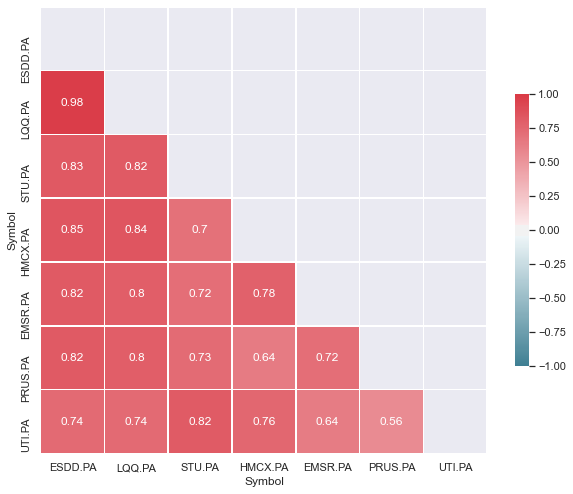

In [40]:
markwitz_asset_list = w_max.loc[w_max > 0.01].index
corr = historical_returns_cov[markwitz_asset_list].corr()
plot_correlation_matrix(corr, figsize = (10,10), annot = True)

## Backtesting

Visualiser l'évolution d'un portefeuille de 1€ investit dans le portfeuille de Markowitz en 2017.

In [20]:
start, end = ['2017-01-01', '2020-12-31']

s, tickers = [], markwitz_asset_list2
for ticker in tickers:
    tick_hist = yf.Ticker(ticker).history(start = start, end = end)
    s.append(tick_hist['Open'])

#(markowitz_assets_open2 * w_max2[markwitz_asset_list2]).sum(axis = 1).plot()

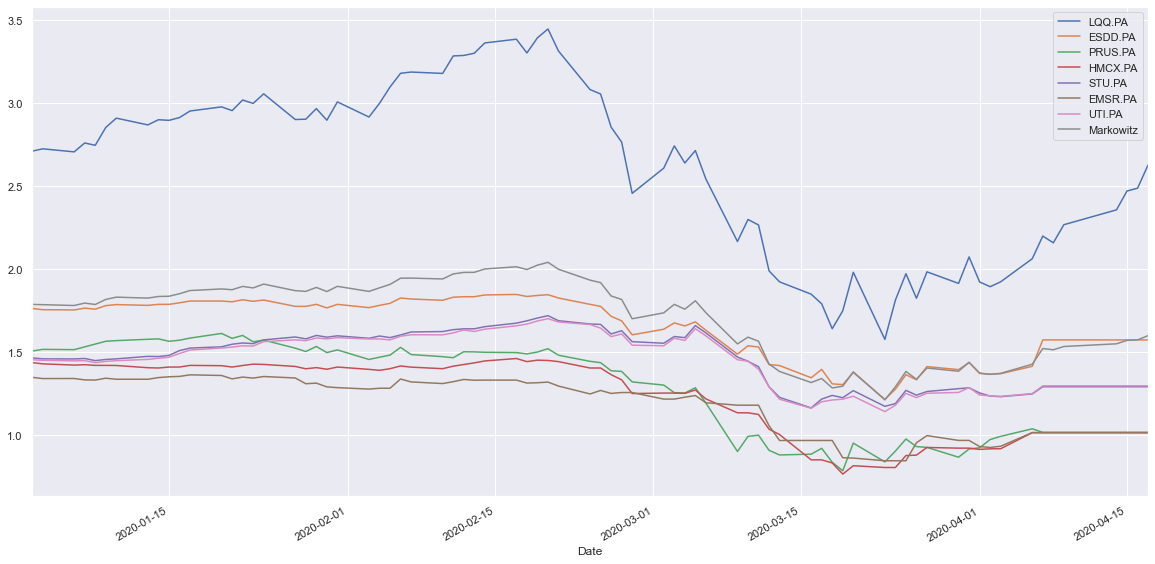

In [35]:
df = pd.DataFrame(s, index= tickers).T
df.fillna(method = 'backfill', axis = 0, inplace = True)
df = (df / df.loc[df.index[0]])
df['Markowitz'] = (df * w_max2).sum(axis = 1)
df.loc[df.index > '2020-01-01'].plot(figsize = (20,10))

In [30]:
mean_historical_return(df)

LQQ.PA       0.378255
ESDD.PA      0.157299
PRUS.PA      0.057948
HMCX.PA      0.026684
STU.PA       0.091984
EMSR.PA      0.023093
UTI.PA       0.092530
Markowitz    0.163295
dtype: float64